In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# 2.Load Dataset
data = pd.read_csv("hanoi_quality.csv")
data

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2019,76,1,15,36,7,7
1,3/2/2019,117,64,4,28,3,5
2,3/3/2019,10,64,1,22,16,5
3,3/4/2019,118,56,13,22,14,6
4,3/5/2019,2,34,15,21,6,6
...,...,...,...,...,...,...,...
1915,5/28/2024,85,56,14,1,8,6
1916,5/29/2024,58,50,13,1,8,6
1917,5/30/2024,47,39,10,1,8,8
1918,5/31/2024,48,63,10,1,8,8


In [3]:
#kích thước dữ liệu
data.shape
data.info()
#Mô tả bộ dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1920 non-null   object
 1   pm25    1920 non-null   int64 
 2   pm10    1920 non-null   int64 
 3   o3      1920 non-null   int64 
 4   no2     1920 non-null   int64 
 5   so2     1920 non-null   int64 
 6   co      1920 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 105.1+ KB


,pm25,pm10,o3,no2,so2,co
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,63.091667,39.147917,16.548958,19.444271,11.690104,7.580208
std,40.260213,21.942295,16.580522,10.014321,6.428450,2.986652
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,32.000000,22.000000,8.000000,13.000000,7.000000,5.000000
50%,54.500000,36.000000,14.000000,19.000000,11.000000,7.000000
75%,88.000000,54.000000,21.000000,27.000000,17.000000,9.000000
max,217.000000,121.000000,441.000000,53.000000,43.000000,21.000000


In [4]:
#Chọn thuộc tính
data = data[['pm25','pm10']]
data = data.dropna() 
data = data.reset_index(drop=True) 
data

,pm25,pm10
0,76,1
1,117,64
2,10,64
3,118,56
4,2,34
...,...,...
1915,85,56
1916,58,50
1917,47,39
1918,48,63


In [5]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)
    
    return forecast_smoothed_filled

# Example usage
data = smoothed(data)

<Axes: >

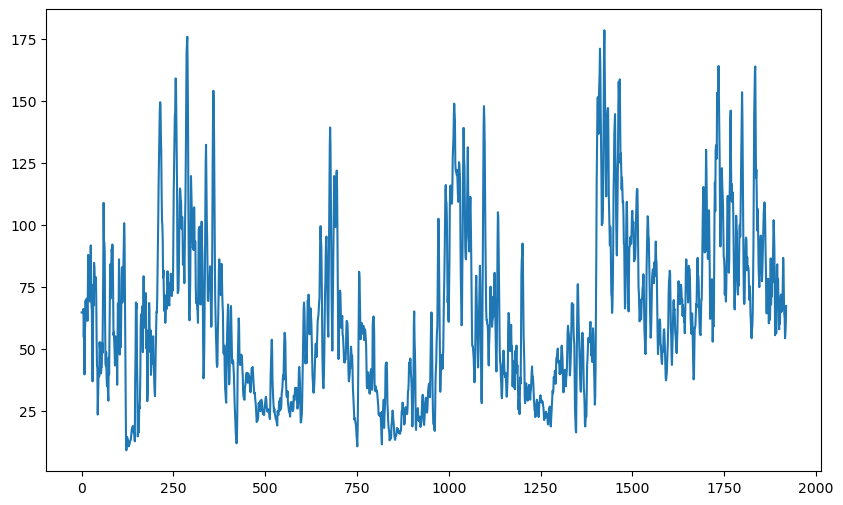

In [6]:
data['pm25'].plot(figsize=(10,6))

In [7]:
# Split the data into training, testing
train_size = int(0.7 * len(data))
test_size = int(0.3 * len(data))

train_data = data[:train_size]
test_data = data[train_size:]

# Kiểm tra kích thước của từng tập
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [8]:
# 3. Quá trình Training
model = VAR(train_data)
model_fitted = model.fit(maxlags =15 , ic='aic')

In [9]:
# 4. Quá trình testing 
# Dự đoán cho cả 'pm25' và 'pm10'
y_pred = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=len(test_data))


In [10]:
y_pred = pd.DataFrame(y_pred, columns=['pm25', 'pm10'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [11]:
y_pred

array([[24.71377916, 17.76527406],
       [24.71377916, 17.76527406],
       [24.71377916, 17.76527406],
       ...,
       [53.35280188, 31.98245821],
       [53.35280915, 31.98246164],
       [53.3528163 , 31.98246502]])

In [12]:

# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index = data.index[-1]

# # Dự đoán cho 90 ngày tiếp theo
y_next_90_days = model_fitted.forecast(data.values[-model_fitted.k_ar:], steps=90)



# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)



Predicted closing prices for the next 90 days:
[[67.48019102 52.72565088]
 [69.8730351  50.56890953]
 [70.02405065 50.72636723]
 [71.42048009 48.23543472]
 [68.43899151 45.96202946]
 [67.2274703  44.96297721]
 [66.59239281 44.28975854]
 [65.99883853 43.1862145 ]
 [64.75469079 42.99107913]
 [64.0648103  44.16464147]
 [65.15594502 44.67614872]
 [65.1053399  44.9781024 ]
 [65.45949506 44.31693551]
 [64.80421952 43.86151894]
 [64.823097   42.49870071]
 [63.21557667 41.38381808]
 [62.46651062 40.24261619]
 [61.19267714 39.92869322]
 [61.04149764 39.5300976 ]
 [60.8464971  39.36568853]
 [61.26182027 39.19619156]
 [61.45025379 39.17222276]
 [61.92023047 39.10431412]
 [62.22340355 38.9936351 ]
 [62.19652225 38.98554731]
 [62.19118067 38.87886476]
 [61.96811433 38.77553216]
 [61.82237784 38.43823285]
 [61.31123758 38.16829746]
 [61.04552774 37.80225185]
 [60.59876649 37.57980777]
 [60.43912127 37.30435236]
 [60.11421553 37.15711951]
 [60.05544414 36.96946343]
 [59.91260589 36.80655213]
 [59.862

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính RMSE
rmse = np.sqrt(mean_squared_error(test_data['pm25'], y_pred[:, 0]))
print('Testing RMSE:', rmse)

# Tính MAE
mae = mean_absolute_error(test_data['pm25'], y_pred[:, 0])
print('\nTesting MAE:', mae)

# Tính MAPE
mape = np.mean(np.abs((test_data['pm25'] - y_pred[:, 0]) / test_data['pm25'])) * 100
print('\nTesting MAPE:', mape)


Testing RMSE: 43.02362358136412

Testing MAE: 33.00408407969163

Testing MAPE: 34.66354937818595


In [14]:
test_data.index

RangeIndex(start=1344, stop=1920, step=1)

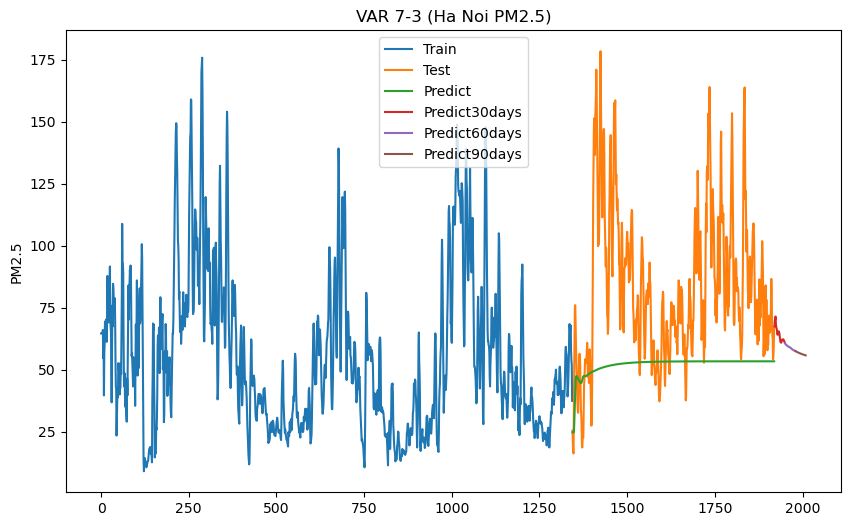

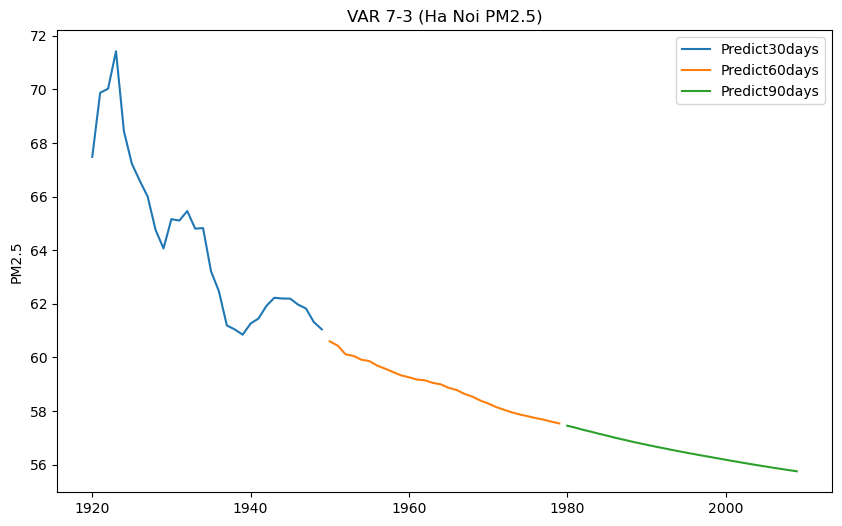

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử last_index và y_next_90_days đã được định nghĩa trước đó
# Bạn có thể thay thế chúng bằng dữ liệu thực tế của mình

# Vẽ biểu đồ huấn luyện và kiểm tra với dự đoán
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['pm25'], label='Train')
plt.plot(test_data.index, test_data['pm25'], label='Test')
plt.plot(test_data.index, y_pred[:, 0], label='Predict')

# Vẽ dự đoán 90 ngày
last_index = data.index[-1]  # Giả sử last_index là index cuối cùng của train_data

last_data = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
plt.plot(last_data, y_next_90_days[0:30][:, 0], label='Predict30days')

last_data = pd.RangeIndex(start=last_index + 31, stop=last_index + 61, step=1)
plt.plot(last_data, y_next_90_days[30:60][:, 0], label='Predict60days')

last_data = pd.RangeIndex(start=last_index + 61, stop=last_index + 91, step=1)
plt.plot(last_data, y_next_90_days[60:90][:, 0], label='Predict90days')

plt.legend()
plt.title('VAR 7-3 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

# Vẽ dự đoán 90 ngày với kích thước 14x7
plt.figure(figsize=(10, 6))
last_data = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
plt.plot(last_data, y_next_90_days[0:30][:, 0], label='Predict30days')

last_data = pd.RangeIndex(start=last_index + 31, stop=last_index + 61, step=1)
plt.plot(last_data, y_next_90_days[30:60][:, 0], label='Predict60days')

last_data = pd.RangeIndex(start=last_index + 61, stop=last_index + 91, step=1)
plt.plot(last_data, y_next_90_days[60:90][:, 0], label='Predict90days')

plt.legend()
plt.title('VAR 7-3 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()
